In [1]:
# 1. Import thư viện cần thiết
# from google.colab import drive
# drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_absolute_error

In [2]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('../Datasets/NVDA Historical Data.csv')
df1=df.reset_index()['Price']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X, y = create_dataset(df1, time_step)

X_train = X[:train_size-100]
X_test = X[train_size-100:train_size-100+test_size]
X_val = X[train_size-100+test_size:]

y_train = y[:train_size-100]
ytest = y[train_size-100:train_size-100+test_size]
yval = y[train_size+test_size-100:]
# time_step = 100
# X_train, y_train = create_dataset(train_data, time_step)
# X_val, yval = create_dataset(val_data, time_step)
# X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 3s 62ms/step - loss: 0.0039 - val_loss: 0.0014
Epoch 2/100
14/14 [==============================] - 0s 25ms/step - loss: 1.9371e-04 - val_loss: 0.0012
Epoch 3/100
14/14 [==============================] - 0s 24ms/step - loss: 1.1757e-04 - val_loss: 8.4357e-04
Epoch 4/100
14/14 [==============================] - 0s 29ms/step - loss: 8.9598e-05 - val_loss: 0.0011
Epoch 5/100
14/14 [==============================] - 0s 25ms/step - loss: 7.9968e-05 - val_loss: 0.0011
Epoch 6/100
14/14 [==============================] - 0s 29ms/step - loss: 7.4397e-05 - val_loss: 0.0011
Epoch 7/100
14/14 [==============================] - 0s 29ms/step - loss: 7.4826e-05 - val_loss: 0.0011
Epoch 8/100
14/14 [==============================] - 0s 34ms/step - loss: 7.1616e-05 - val_loss: 0.0012
Epoch 9/100
14/14 [==============================] - 0s 30ms/step - loss: 6.8539e-05 - val_loss: 0.0012
Epoch 10/100
14/14 [==============================] - 0s 35ms/st

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

6/6 [==============================] - 0s 7ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [12]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE, MAE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAE:', valid_mae)

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)

Validation RMSE: 224.88294580105037
Validation MAE: 216.32855148658777
Testing RMSE: 192.63333823541106
Testing MAE: 186.3090008324674


In [13]:
# 13. Dự báo 30 ngày tiếp theo
n_steps=time_step
x_input=val_data[-n_steps:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]

i=0
while(i<30):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.8414779]
101
1 day input [0.41704014 0.42883526 0.44269884 0.4130756  0.42230978 0.45693179
 0.47579414 0.46079783 0.46052696 0.4872199  0.48800788 0.49125831
 0.46486087 0.47773947 0.50687023 0.50177296 0.48300911 0.46788968
 0.44983994 0.45227776 0.52393499 0.51462694 0.5199212  0.51290323
 0.50014775 0.51531642 0.52950012 0.5212263  0.51467619 0.53666585
 0.51832061 0.50672248 0.50674711 0.53376016 0.5378232  0.57015513
 0.57468604 0.57899532 0.58635804 0.59298202 0.61078552 0.60064024
 0.59453337 0.5915538  0.60568825 0.61551342 0.62521546 0.62984487
 0.61723713 0.60315193 0.60699335 0.62033982 0.61024378 0.59364689
 0.5928589  0.60012312 0.60613149 0.62250677 0.62900763 0.60864319
 0.60901256 0.60711647 0.58739227 0.60499877 0.61164738 0.62452598
 0.653115   0.63587786 0.62583108 0.6199212  0.64745137 0.6590495
 0.6447673  0.65249938 0.64493967 0.63907904 0.65417385 0.66057621
 0.68433883 0.72127555 0.71108101 0.70891406 0.69689732 0.69320364
 0.876459   0.90024624 0.92893376 0

Validation RMSE: 224.88294580105037
Validation MAE: 216.32855148658777
Testing RMSE: 192.63333823541106
Testing MAE: 186.3090008324674


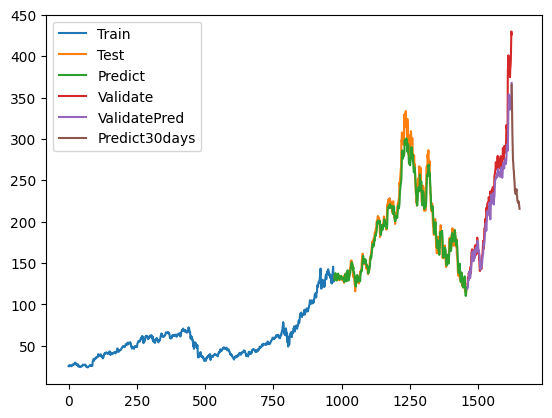

[[0.8414778709411621], [0.8046896457672119], [0.7372487187385559], [0.6858288645744324], [0.6510161757469177], [0.6158434748649597], [0.6082435846328735], [0.5905038118362427], [0.5864320397377014], [0.5696704983711243], [0.5578308701515198], [0.5469262003898621], [0.5257888436317444], [0.5300095081329346], [0.5167141556739807], [0.5188395380973816], [0.5228723287582397], [0.5262333750724792], [0.5305503606796265], [0.5135055780410767], [0.50975102186203], [0.49814140796661377], [0.4938903748989105], [0.4931623935699463], [0.4901498556137085], [0.494701087474823], [0.48905089497566223], [0.4861893951892853], [0.4789825677871704], [0.4721497595310211]]


In [14]:
# 14.Vẽ hình
print('Validation RMSE:', valid_rmse)
print('Validation MAE:', valid_mae)

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()
print(lst_output)

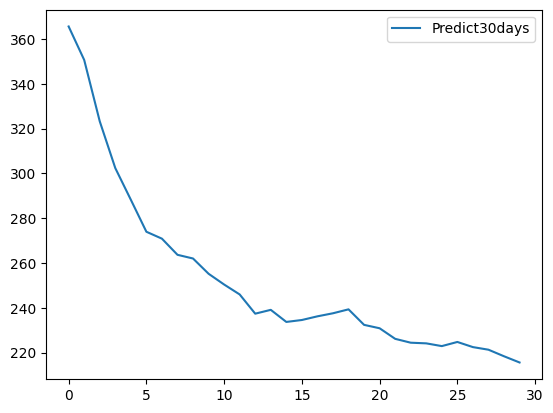

In [15]:
# 15.Vẽ hình Predict 30 days
prediect_data_index = pd.RangeIndex(start=0, stop=30, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Predict30days'])
plt.show()

In [16]:
scaler.inverse_transform(lst_output)[:6, 0]

array([365.59416339, 350.65446515, 323.26670468, 302.3851019 ,
       288.24766897, 273.96403514])